In [39]:
!nvidia-smi

Sun Aug 14 15:39:58 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 516.94       Driver Version: 516.94       CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0  On |                  N/A |
|  0%   55C    P8    19W / 210W |    972MiB /  8192MiB |     10%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# 資料讀取與前處理

In [57]:
###### 資料讀取 實際測試時此區改為讀取攔截之封包資料
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

csv_files = []
for dirname, _, filenames in os.walk('MachineLearningCSV/MachineLearningCVE'):
    for filename in filenames:
        csv_file = os.path.join(dirname, filename)
        print(os.path.join(dirname, filename))
        csv_files.append(csv_file)

# df = pd.concat([pd.read_csv(file) for file in csv_files[:8]], ignore_index=True)
df = pd.read_csv("MachineLearningCSV/MachineLearningCVE/week_2.csv",index_col = 0)

df.columns = df.columns.str.strip()
print("original length of df:", len(df))
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)
print("after droping null values, the length of df:", len(df))

MachineLearningCSV/MachineLearningCVE\Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv
MachineLearningCSV/MachineLearningCVE\Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv
MachineLearningCSV/MachineLearningCVE\Friday-WorkingHours-Morning.pcap_ISCX.csv
MachineLearningCSV/MachineLearningCVE\Monday-WorkingHours.pcap_ISCX.csv
MachineLearningCSV/MachineLearningCVE\Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv
MachineLearningCSV/MachineLearningCVE\Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv
MachineLearningCSV/MachineLearningCVE\Tuesday-WorkingHours.pcap_ISCX.csv
MachineLearningCSV/MachineLearningCVE\Wednesday-workingHours.pcap_ISCX.csv
MachineLearningCSV/MachineLearningCVE\week.csv
MachineLearningCSV/MachineLearningCVE\week_2.csv
original length of df: 2830743
after droping null values, the length of df: 2827876


In [58]:
###### 針對標籤之處理，實際測試攔截封包資料時可拿掉
df_experiment = df.copy()
df_experiment.Label.replace("Web.*", "Web Attack", regex=True, inplace=True)
df_experiment.Label.replace(r'.*Patator$', "Brute Force", regex=True,inplace=True)
df_experiment.Label.replace(["DoS GoldenEye", "DoS Hulk", "DoS Slowhttptest", "DoS slowloris"], "DoS", inplace=True)

class_attack = ['PortScan', 'Web Attack', 'Brute Force', 'DDoS', 'Bot','Infiltration', 'DoS', 'Heartbleed']
df_experiment.Label.replace(class_attack, value='attack', inplace=True)
df_experiment.Label.value_counts()

BENIGN    2271320
attack     556556
Name: Label, dtype: int64

In [69]:
# data split and preprocess
from sklearn.model_selection import train_test_split
import joblib

std_scaler,mm_scaler,le = joblib.load("model/std_mm_le_new.save")

y = df_experiment.Label
X = df_experiment.drop(columns='Label')
labels = y.unique()

X = std_scaler.transform(X)

classes = y.nunique()
print(X.shape)
print("number of labels:", classes)
print("instances per label\n", y.value_counts())
print("labels:", labels)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

print("after spliting the data:\n")
print("training data length:", len(X_train))
print("test data length:", len(X_test))

X_train = mm_scaler.transform(X_train)
X_test = mm_scaler.transform(X_test)

print("after MinMaxScaler")
print(X_train.shape)

#標籤編碼 可不跑
# y_train = le.transform(y_train)
# y_test = le.transform(y_test)

In [60]:
###### Random Forest
import joblib

rng = np.random.RandomState(42)

model = joblib.load("model/pkl/new_randomForest_32.pkl")
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

print(y_train_pred)
print(y_train_pred.shape)
print(y_test_pred)
print(y_test_pred.shape)

print("percentage of Anomaly:", (list(y_test_pred).count(1)/y_test_pred.shape[0])*100)
print("percentage of Legit:",(list(y_test_pred).count(0)/y_test_pred.shape[0])*100)

[0 0 0 ... 1 0 1]
(2120907,)
[0 0 1 ... 0 0 0]
(706969,)
percentage of Anomaly: 19.7059559895837
percentage of Legit: 80.2940440104163


In [68]:
y_train_pred


array([0, 0, 0, ..., 1, 0, 1])

In [70]:
y_train

array([0, 0, 0, ..., 1, 0, 1])

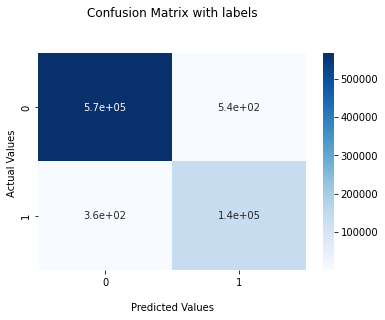

In [72]:
import seaborn as sns
import matplotlib.pyplot as plt 
from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(y_test, y_test_pred)
tn, fp, fn, tp = cf_matrix.ravel()
cf_matrix

ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

ax.set_title('Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

plt.show()
# plt.savefig('img/new_confusion_matrix_32.png')

In [17]:
from sklearn.metrics import confusion_matrix

cf_matrix = confusion_matrix(y_train, y_train_pred)
tn, fp, fn, tp = cf_matrix.ravel()
cf_matrix

array([[1702181,    1309],
       [    596,  416821]], dtype=int64)

# Test for CICFLOWMETER Data

### All Feature

In [118]:
###### 資料讀取 實際測試時此區改為讀取攔截之封包資料
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

df = pd.read_csv("MachineLearningCSV/testflows.csv")

df.columns = df.columns.str.strip()
print("original length of df:", len(df))
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)
print("after droping null values, the length of df:", len(df))

original length of df: 1335
after droping null values, the length of df: 1335


In [119]:
df = df.drop(["src_ip" , "dst_ip", "src_port", "src_mac", "dst_mac", "protocol", "timestamp"], axis = 1)
df

In [123]:
# 使用資料集前處理
from sklearn.model_selection import train_test_split
import joblib

std_scaler,mm_scaler,le = joblib.load("model/std_mm_le_new.save")

X = df

X = std_scaler.transform(X)

print("after StandardScaler")
print(X.shape)

X = mm_scaler.transform(X)

print("after MinMaxScaler")
print(X.shape)

#標籤編碼 可不跑
# y_train = le.transform(y_train)
# y_test = le.transform(y_test)

after StandardScaler
(1335, 76)
after MinMaxScaler
(1335, 76)


In [ ]:
# 資料內自行前處理
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler

X = df

std_scaler = preprocessing.StandardScaler().fit(X)
X = std_scaler.transform(X)

mm_scaler = MinMaxScaler()
X = mm_scaler.fit_transform(X)

In [124]:
###### Random Forest
import joblib

rng = np.random.RandomState(42)

model = joblib.load("model/pkl/new_no_port_randomForest_32.pkl")
X_pred = model.predict(X)

print(X_pred)
print(X_pred.shape)

print("percentage of Anomaly:", (list(X_pred).count(1)/X_pred.shape[0])*100)
print("percentage of Legit:",(list(X_pred).count(0)/X_pred.shape[0])*100)

[0 0 0 ... 0 0 0]
(1335,)
percentage of Anomaly: 0.0
percentage of Legit: 100.0


### Delete dst port

In [ ]:
###### 資料讀取 實際測試時此區改為讀取攔截之封包資料
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

df = pd.read_csv("MachineLearningCSV/testflows.csv")

df.columns = df.columns.str.strip()
print("original length of df:", len(df))
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)
print("after droping null values, the length of df:", len(df))

In [ ]:
df = df.drop(["src_ip" , "dst_ip", "src_port", "dst_port", "src_mac", "dst_mac", "protocol", "timestamp"], axis = 1)
df

In [ ]:
# 使用資料集前處理
from sklearn.model_selection import train_test_split
import joblib

std_scaler,mm_scaler,le = joblib.load("model/std_mm_le_new.save")

X = df

X = std_scaler.transform(X)

print("after StandardScaler")
print(X.shape)

X = mm_scaler.transform(X)

print("after MinMaxScaler")
print(X.shape)

#標籤編碼 可不跑
# y_train = le.transform(y_train)
# y_test = le.transform(y_test)

In [ ]:
# 資料內自行前處理
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler

X = df

std_scaler = preprocessing.StandardScaler().fit(X)
X = std_scaler.transform(X)

mm_scaler = MinMaxScaler()
X = mm_scaler.fit_transform(X)

In [ ]:
###### Random Forest
import joblib

rng = np.random.RandomState(42)

model = joblib.load("model/pkl/new_no_port_randomForest_32.pkl")
X_pred = model.predict(X)

print(X_pred)
print(X_pred.shape)

print("percentage of Anomaly:", (list(X_pred).count(1)/X_pred.shape[0])*100)
print("percentage of Legit:",(list(X_pred).count(0)/X_pred.shape[0])*100)

### 20 Feature

In [13]:
###### 資料讀取 實際測試時此區改為讀取攔截之封包資料
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

df = pd.read_csv("MachineLearningCSV/testflows10.csv")

df.columns = df.columns.str.strip()
print("original length of df:", len(df))
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)
print("after droping null values, the length of df:", len(df))

original length of df: 1335
after droping null values, the length of df: 1335


In [14]:
df = df[["flow_duration" , "bwd_pkt_len_max", "bwd_pkt_len_min", "bwd_pkt_len_mean", "bwd_pkt_len_std", "flow_iat_std", "flow_iat_max", "fwd_iat_tot", "fwd_iat_std", "fwd_iat_max", 
         "pkt_len_min", "pkt_len_max", "pkt_len_mean", "pkt_len_std", "pkt_len_var", "pkt_size_avg", "bwd_seg_size_avg", "idle_mean", "idle_max", "idle_min"]]
df

,flow_duration,bwd_pkt_len_max,bwd_pkt_len_min,bwd_pkt_len_mean,bwd_pkt_len_std,flow_iat_std,flow_iat_max,fwd_iat_tot,fwd_iat_std,fwd_iat_max,pkt_len_min,pkt_len_max,pkt_len_mean,pkt_len_std,pkt_len_var,pkt_size_avg,bwd_seg_size_avg,idle_mean,idle_max,idle_min
0,3420105.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,342,348,345.0,3.0,9.0,345.0,0.0,0.0,0.0,0.0
1,98821.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,69,69,69.0,0.0,0.0,69.0,0.0,0.0,0.0,0.0
2,108548.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,66,66,66.0,0.0,0.0,66.0,0.0,0.0,0.0,0.0
3,189958.0,187.0,187.0,187.0,0.0,0.0,0.0,0.0,0.0,0.0,85,187,136.0,51.0,2601.0,136.0,187.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,342,342,342.0,0.0,0.0,342.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1330,171268.0,60.0,60.0,60.0,0.0,0.0,0.0,0.0,0.0,0.0,54,60,57.0,3.0,9.0,57.0,60.0,0.0,0.0,0.0
1331,173828.0,60.0,60.0,60.0,0.0,0.0,0.0,0.0,0.0,0.0,54,60,57.0,3.0,9.0,57.0,60.0,0.0,0.0,0.0
1332,426.0,60.0,60.0,60.0,0.0,0.0,0.0,0.0,0.0,0.0,54,60,57.0,3.0,9.0,57.0,60.0,0.0,0.0,0.0
1333,144.0,60.0,60.0,60.0,0.0,0.0,0.0,0.0,0.0,0.0,54,60,57.0,3.0,9.0,57.0,60.0,0.0,0.0,0.0


In [11]:
# 使用資料集前處理
from sklearn.model_selection import train_test_split
import joblib

std_scaler,mm_scaler,le = joblib.load("model/std_mm_le_20_feature.save")

X = df

X = std_scaler.transform(X)

print("after StandardScaler")
print(X.shape)

X = mm_scaler.transform(X)

print("after MinMaxScaler")
print(X.shape)

#標籤編碼 可不跑
# y_train = le.transform(y_train)
# y_test = le.transform(y_test)

after StandardScaler
(1335, 20)
after MinMaxScaler
(1335, 20)


In [15]:
# 資料內自行前處理
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler

X = df

std_scaler = preprocessing.StandardScaler().fit(X)
X = std_scaler.transform(X)

mm_scaler = MinMaxScaler()
X = mm_scaler.fit_transform(X)

In [16]:
###### Random Forest
import joblib

rng = np.random.RandomState(42)

model = joblib.load("model/pkl/new_20_feature_randomForest_32.pkl")
X_pred = model.predict(X)

print(X_pred)
print(X_pred.shape)

print("percentage of Anomaly:", (list(X_pred).count(1)/X_pred.shape[0])*100)
print("percentage of Legit:",(list(X_pred).count(0)/X_pred.shape[0])*100)

[0 0 0 ... 0 0 0]
(1335,)
percentage of Anomaly: 2.9213483146067416
percentage of Legit: 97.07865168539325


# Test

In [110]:
model

[StandardScaler(), MinMaxScaler(), LabelEncoder()]

In [126]:
estimator = model.estimators_

In [127]:
len(estimator)

32

[Text(248.29317840300715, 214.78829268292682, 'X[31] <= 0.559\ngini = 0.316\nsamples = 1340572\nvalue = [1703884, 417023]'),
 Text(164.25990165012973, 209.48487804878047, 'X[53] <= 0.004\ngini = 0.254\nsamples = 1247660\nvalue = [1678685, 295233]'),
 Text(65.92895947112227, 204.18146341463415, 'X[0] <= 0.0\ngini = 0.025\nsamples = 592470\nvalue = [926470, 11679]'),
 Text(46.79392644031367, 198.8780487804878, 'X[35] <= 0.0\ngini = 0.042\nsamples = 286218\nvalue = [443651, 9776]'),
 Text(28.745641609886018, 193.57463414634145, 'X[2] <= 0.333\ngini = 0.032\nsamples = 284488\nvalue = [443441, 7291]'),
 Text(5.160580165848055, 188.2712195121951, 'X[54] <= 0.004\ngini = 0.322\nsamples = 8470\nvalue = [10716, 2712]'),
 Text(3.062484092714395, 182.96780487804878, 'X[13] <= 0.0\ngini = 0.023\nsamples = 6192\nvalue = [9737, 114]'),
 Text(2.826908393274826, 177.66439024390243, 'X[18] <= 0.002\ngini = 0.068\nsamples = 2033\nvalue = [3127, 114]'),
 Text(2.3557569943956884, 172.3609756097561, 'X[28]

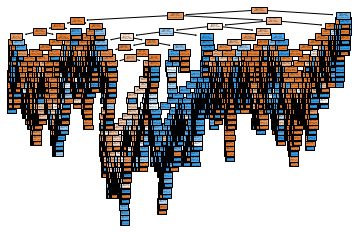

In [128]:
from sklearn import tree
tree.plot_tree(estimator[0], filled = True)